In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'grid'])   
import xarray

import os
import sys
import re
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pyproj
import datetime
from tqdm import tqdm

import dynamic_tasker.imagery as imagery
from dynamic_tasker.access import *
from dynamic_tasker.orbits import *
from dynamic_tasker.constants import *
from dynamic_tasker.cameras import *
from dynamic_tasker.schedulers import *

%load_ext autoreload
%autoreload 2

In [2]:
# Download himawari-9 data
date = datetime.datetime(2025, 1, 1, 0, 0)

# os.chdir('/mnt/c/Users/shree/phd_code/notebooks/exploration')

print("Downloading himawari-9 data for date: ", date)
imagery.download_himawari_image(date)
print("Downloading GOES East data for date: ", date)
imagery.download_goes_east_image(date)
print("Downloading GOES West data for date: ", date)
imagery.download_goes_west_image(date)
print("Downloading Meteosat ZDS data for date: ", date)
imagery.download_meteosat_zds_image(date)
print("Downloading Meteosat IODC data for date: ", date)
imagery.download_meteosat_iodc_image(date)

c:\Users\shree\AppData\Local\Programs\Python\Python312\Lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-himawari9.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
c:\Users\shree\AppData\Local\Programs\Python\Python312\Lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-himawari9.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


KeyboardInterrupt: 

In [2]:
# Load all the data...

all_data = [imagery.load_bcm(f"../../data/products/{x}_{date.strftime(imagery.dateformat)}.{'grb' if x.startswith('meteosat') else 'nc'}") for x in ["goes_west", "goes_east","meteosat_zds", "meteosat_iodc", "himawari"]]
center_lats = [x["lon"] for x in imagery.image_sources.values()]

NameError: name 'date' is not defined

In [ ]:
def sample_global_point(all_data, points):
    center_lon_sorted = np.sort(center_lats)
    center_lon_cutoffs = (center_lon_sorted + np.roll(center_lon_sorted, 1)) / 2
    center_lon_cutoffs[0] -= 180

    mask = np.zeros(len(points))
    for i, p in tqdm(enumerate(points), total=len(points)):
        lat, lon = p

        sat_idx = np.searchsorted(center_lon_cutoffs, lon)

        if sat_idx == 0:
            sat_idx = 5

        data, lats, lons = all_data[sat_idx - 1]

        mask[i] = imagery.get_closest_latlong_sample(data, lats, lons, p)
    
    return mask

print(sample_global_point(all_data, [(0, 100)]))


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1029.02it/s]

[1.]


In [ ]:
N_lat = 1000
N_lon = 3000
lat_grid = np.linspace(-60, 60, N_lat)
lon_grid = np.linspace(-180, 180, N_lon)

lons, lats = np.meshgrid(lon_grid, lat_grid)

points = np.stack([lats.flatten(), lons.flatten()], axis=1)
# print(points)

# Sample all points...

mask = sample_global_point(all_data, points).reshape(lats.shape)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000000/3000000 [03:34<00:00, 13971.36it/s]


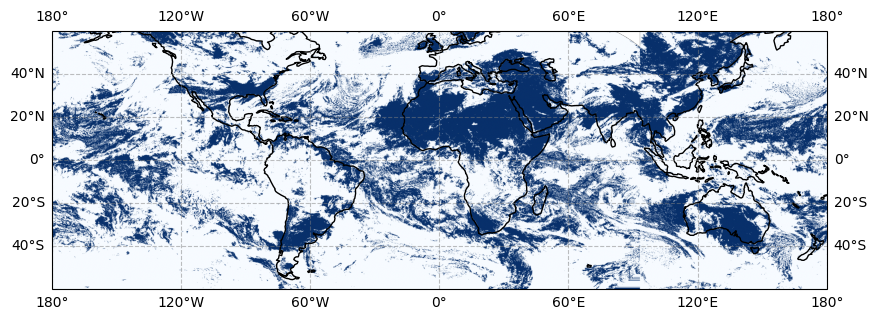

In [ ]:
fig = plt.figure(figsize=(10, 10))
# Create a cartopy GeoAxes with PlateCarree projection
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the data using imshow, specifying the transform and extent
im = ax.imshow(
    mask[0], 
    origin='lower', 
    extent=[-180, 180, -60, 60],  # adjust if needed
    transform=ccrs.PlateCarree(), 
    cmap='Blues_r'
)

# Add coastlines
ax.coastlines()

# Add gridlines for latitude and longitude
gridlines = ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.5)
gridlines.xlabels_top = False  # Disable labels at the top
gridlines.ylabels_right = False  # Disable labels on the right

# plt.title(f"Cloud mask for {date}")
plt.show()

In [ ]:
# Satellite
requests = load_worldcities(10000)
h = 400
t0 = datetime.datetime(2025, 1, 1, 12, 0, 0)
orbit = circular_orbit(a=Constants.R_E+h, i=np.deg2rad(51.6), Omega=np.pi, M=np.pi/2, t=t0)
t_end = datetime.datetime(2025, 1, 2, 12, 0, 0)
accesses = get_accesses(requests, orbit, 500, 30, t0, t_end)


In [ ]:
round_to = 30 # minutes for rounding

center_lon_sorted = np.sort(center_lats)
center_lon_cutoffs = (center_lon_sorted + np.roll(center_lon_sorted, 1)) / 2
center_lon_cutoffs[0] -= 180

unique_maps = []

CoverageZone = namedtuple("CoverageZone", ["sat_idx", "time"])

for a in accesses:
    # Round down to nearest 30 minutes
    t = a.time
    t = t.replace(second=0, microsecond=0)
    t = t - datetime.timedelta(minutes=t.minute % round_to)

    sat_idx = np.searchsorted(center_lon_cutoffs, a.long) - 1

    if(sat_idx == -1):
        sat_idx = 4

    if(len(unique_maps) == 0 or ((unique_maps[-1].time != t or unique_maps[-1].sat_idx != sat_idx) and (len(unique_maps) == 1 or unique_maps[-2].time != t or unique_maps[-2].sat_idx != sat_idx))):
        unique_maps.append(CoverageZone(sat_idx, t))
        print(f"New map at {t} with long {a.long} for satellite {list(imagery.image_sources.values())[sat_idx]['description']}")
# Now, download all the maps...
def get_sat_idx(long):
    center_lon_sorted = np.sort(center_lats)
    center_lon_cutoffs = (center_lon_sorted + np.roll(center_lon_sorted, 1)) / 2
    center_lon_cutoffs[0] -= 180

    sat_idx = np.searchsorted(center_lon_cutoffs, long) - 1

    if(sat_idx == -1):
        sat_idx = 4

    return sat_idx

def download_coverage_map(time, sat_idx):
    # sat_idx = get_sat_idx(long)

    # Now, download...

    dl_funcs = [imagery.download_goes_west_image, imagery.download_goes_east_image, imagery.download_meteosat_zds_image, imagery.download_meteosat_iodc_image, imagery.download_himawari_image]

    print(f"Downloading {list(imagery.image_sources.values())[sat_idx]['description']} image for time {time} with {dl_funcs[sat_idx]}")
    dl_funcs[sat_idx](time)

for m in unique_maps:
    download_coverage_map(m.time, m.sat_idx)



New map at 2025-01-01 12:00:00 with long -9.0489 for satellite Meteosat Zero Degree Service (ZDS)
New map at 2025-01-01 12:00:00 with long 22.89 for satellite Meteosat Indian Ocean Data Coverage (IODC)
New map at 2025-01-01 13:00:00 with long -104.3158 for satellite GOES East (16)
New map at 2025-01-01 13:30:00 with long -4.49 for satellite Meteosat Zero Degree Service (ZDS)
New map at 2025-01-01 13:30:00 with long 23.9614 for satellite Meteosat Indian Ocean Data Coverage (IODC)
New map at 2025-01-01 14:00:00 with long 170.5036 for satellite Himawari 9
New map at 2025-01-01 14:30:00 with long -116.6058 for satellite GOES West (18)
New map at 2025-01-01 14:30:00 with long -104.6114 for satellite GOES East (16)
New map at 2025-01-01 15:00:00 with long -84.35 for satellite GOES East (16)
New map at 2025-01-01 15:00:00 with long -8.65 for satellite Meteosat Zero Degree Service (ZDS)
New map at 2025-01-01 15:00:00 with long 25.2 for satellite Meteosat Indian Ocean Data Coverage (IODC)
New m

/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.eumetsat.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.eumetsat.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.eumetsat.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.eumetsat.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-goes16.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-goes16.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.eumetsat.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.eumetsat.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.eumetsat.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.eumetsat.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-himawari9.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-himawari9.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-goes18.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-goes18.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-goes16.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-goes16.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-goes16.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-goes16.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.eumetsat.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.eumetsat.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.eumetsat.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.eumetsat.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.eumetsat.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.eumetsat.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-himawari9.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-himawari9.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-goes18.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-goes18.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-goes18.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-goes18.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-goes16.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-goes16.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.eumetsat.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.eumetsat.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.eumetsat.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.eumetsat.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.eumetsat.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.eumetsat.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-himawari9.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-himawari9.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-goes18.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-goes18.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-goes16.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-goes16.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-goes18.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-goes18.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-goes16.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-goes16.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-goes16.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-goes16.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.eumetsat.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.eumetsat.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-himawari9.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-himawari9.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-goes18.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-goes18.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-goes16.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-goes16.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-goes16.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-goes16.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-himawari9.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-himawari9.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-himawari9.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-himawari9.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-goes18.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-goes18.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-goes18.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-goes18.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-goes16.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-goes16.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.eumetsat.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.eumetsat.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-himawari9.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-himawari9.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.eumetsat.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.eumetsat.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-goes16.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-goes16.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.eumetsat.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.eumetsat.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.eumetsat.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.eumetsat.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-himawari9.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-himawari9.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-goes16.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-goes16.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.eumetsat.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.eumetsat.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.eumetsat.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.eumetsat.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.eumetsat.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.eumetsat.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-himawari9.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-himawari9.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-himawari9.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-himawari9.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-goes16.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-goes16.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.eumetsat.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.eumetsat.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.eumetsat.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.eumetsat.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-himawari9.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-himawari9.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-himawari9.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-himawari9.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-goes16.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-goes16.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.eumetsat.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.eumetsat.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.eumetsat.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.eumetsat.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.eumetsat.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.eumetsat.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-himawari9.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-himawari9.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-goes16.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-goes16.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-goes16.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-goes16.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.eumetsat.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.eumetsat.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.eumetsat.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.eumetsat.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.eumetsat.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.eumetsat.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-himawari9.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-himawari9.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-himawari9.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-himawari9.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-goes16.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-goes16.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.eumetsat.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.eumetsat.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.eumetsat.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.eumetsat.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.eumetsat.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.eumetsat.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-himawari9.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-himawari9.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-himawari9.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-himawari9.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-goes16.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-goes16.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.eumetsat.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.eumetsat.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.eumetsat.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.eumetsat.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-himawari9.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/shreeyam/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'noaa-himawari9.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [ ]:
# OK, now we have all the maps. Let's obtain access status...
old_cov_idx = -1
# Load data...
labels = ["goes_west", "goes_east","meteosat_zds", "meteosat_iodc", "himawari"]
rng = np.random.default_rng()

for a in tqdm(accesses):
    t = a.time
    t = t.replace(second=0, microsecond=0)
    t = t - datetime.timedelta(minutes=t.minute % round_to)

    sat_idx = get_sat_idx(a.long)
    # find the cov idx...
    for i, m in enumerate(unique_maps):
        if((sat_idx, t) == (m.sat_idx, m.time)):
            cov_idx = i
            break

    # if((sat_idx, t) != (unique_maps[cov_idx].sat_idx, unique_maps[cov_idx].time) or cov_idx == -1):
    #     cov_idx += 1

    if(cov_idx != old_cov_idx):
        data, lats, lons = imagery.load_bcm(f"../../data/products/{labels[sat_idx]}_{t.strftime(imagery.dateformat)}.{'grb' if labels[sat_idx].startswith('meteosat') else 'nc'}")
        old_cov_idx = cov_idx

    # data, lats, lons = all_data[sat_idx]

    mask = imagery.get_closest_latlong_sample(data, lats, lons, (a.lat, a.long))

    a.state = mask
    a.utility = rng.pareto(2) + 1

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7155/7155 [02:58<00:00, 40.16it/s]


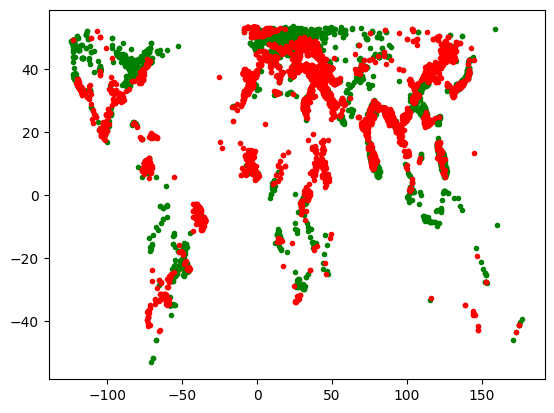

[(9112, 3), (9866, 3), (1552, 3), (6606, 3), (4694, 3), (6063, 3), (6656, 3), (7201, 3), (8703, 3), (6949, 3)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[

In [ ]:
# Clear ones in green
plt.plot([a.long for a in accesses if a.state == 1], [a.lat for a in accesses if a.state == 1], 'g.')
# Blocked ones in red
plt.plot([a.long for a in accesses if a.state == 0], [a.lat for a in accesses if a.state == 0], 'r.')
plt.show()

# Find most common

from collections import Counter
c = Counter([a.requestid for a in accesses])
print(c.most_common(10))

for a in c.most_common(2000):
    b = [x for x in accesses if x.requestid == a[0]]
    print([x.state for x in b if np.any(x.state == 0) and np.any(x.state == 1)])

In [ ]:
# Now let's try the conventional and the omniscient schedulers...

t_s = 20
t_dotsq = 16

def agility_bangbang(theta):
    return t_s + t_dotsq * np.sqrt(np.abs(theta))

schedule_conventional = milp_schedule(accesses, requests, agility_bangbang)
 

feasible solution found by trivial heuristic after 0.2 seconds, objective value 2.018419e+00
presolving:
(round 1, fast)       28 del vars, 15 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 431702 clqs
(round 2, fast)       39 del vars, 24 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 431693 clqs
(round 3, exhaustive) 40 del vars, 25 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 431692 upgd conss, 0 impls, 431692 clqs
   (2.2s) probing: 51/7114 (0.7%) - 0 fixings, 0 aggregations, 0 implications, 0 bound changes
   (2.2s) probing aborted: 50/50 successive totally useless probings
   (3.8s) symmetry computation started: requiring (bin +, int +, cont +), (fixed: bin -, int -, cont -)
   (3.9s) no symmetry present (symcode time: 0.03)
presolving (4 rounds: 4 fast, 2 medium, 2 exhaustive):
 3554 deleted vars, 119562 deleted constraints, 0 added constraints, 0 tightened bounds, 0 added holes

In [ ]:
# Now, let's try the omniscient scheduler...
# Remake accesses...
accesses_omni = [x for x in accesses if x.state == 1]

schedule_omniscient = milp_schedule(accesses_omni, requests, agility_bangbang)

1 |     0 | 13422 |     - |  2277M |   0 |3601 | 312k| 312k| 672 | 36 |   0 |   0 | 2.281547e+03 | 1.464489e+03 |  55.79%| unknown
  982s|     1 |     0 | 13518 |     - |  2279M |   0 |3601 | 312k| 312k| 676 | 37 |   0 |   0 | 2.251076e+03 | 1.464489e+03 |  53.71%| unknown
  982s|     1 |     0 | 13600 |     - |  2282M |   0 |3601 | 312k| 312k| 680 | 38 |   0 |   0 | 2.230326e+03 | 1.464489e+03 |  52.29%| unknown
  982s|     1 |     0 | 13647 |     - |  2284M |   0 |3601 | 312k| 312k| 683 | 39 |   0 |   0 | 2.217927e+03 | 1.464489e+03 |  51.45%| unknown
  982s|     1 |     0 | 13744 |     - |  2287M |   0 |3601 | 312k| 312k| 687 | 40 |   0 |   0 | 2.183157e+03 | 1.464489e+03 |  49.07%| unknown
  983s|     1 |     0 | 13807 |     - |  2287M |   0 |3601 | 312k| 312k| 690 | 41 |   0 |   0 | 2.169691e+03 | 1.464489e+03 |  48.15%| unknown
  983s|     1 |     0 | 13865 |     - |  2289M |   0 |3601 | 312k| 312k| 693 | 42 |   0 |   0 | 2.156262e+03 | 1.464489e+03 |  47.24%| unknown
 time | nod

feasible solution found by trivial heuristic after 0.1 seconds, objective value 8.532167e+00
presolving:
(round 1, fast)       39 del vars, 15 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 179252 clqs
(round 2, fast)       51 del vars, 29 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 179238 clqs
(round 3, exhaustive) 52 del vars, 29 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 179238 upgd conss, 0 impls, 179238 clqs
   (0.8s) probing: 51/3391 (1.5%) - 0 fixings, 0 aggregations, 0 implications, 0 bound changes
   (0.8s) probing aborted: 50/50 successive totally useless probings
   (1.3s) symmetry computation started: requiring (bin +, int +, cont +), (fixed: bin -, int -, cont -)
   (1.3s) no symmetry present (symcode time: 0.01)
presolving (4 rounds: 4 fast, 2 medium, 2 exhaustive):
 2557 deleted vars, 73597 deleted constraints, 0 added constraints, 0 tightened bounds, 0 added holes,

In [407]:
# Evaluate them...
print("Conventional schedule:")
print(schedule_conventional)
print("Omniscient schedule:")
print(schedule_omniscient)

# Evaluate utility

def evaluate_schedule(schedule,):
    utility = 0
    n = len(schedule)

    for s in schedule:
        if(np.isnan(s.state)):
            s.state = 0

        utility += s.utility * s.state
        # print(f"Util\ity: {s.utility} State: {s.state}")

    n_zero = np.sum([s.state == 0 for s in schedule])
    return utility, n, n_zero

print("Conventional utility: ", evaluate_schedule(schedule_conventional))
print("Omniscient utility: ", evaluate_schedule(schedule_omniscient))

Conventional schedule:
[Access(3000, 51.8972, -8.47, Cork, 2025-01-01 12:00:25.878906, 5.232955129262446, 1.0, 1.1215654959970653), Access(8256, 48.93, 2.45, Drancy, 2025-01-01 12:02:22.089844, -26.164085357161003, 1.0, 25.84727329067536), Access(8664, 48.0817, 7.3556, Colmar, 2025-01-01 12:03:16.777344, -26.91289138634757, 1.0, 7.47608781520257), Access(3553, 47.0722, 21.9211, Oradea, 2025-01-01 12:05:50.097656, 13.165821250733305, 1.0, 6.895810562285982), Access(8895, 45.19, 28.8, Tulcea, 2025-01-01 12:07:11.152344, 24.021042846501278, 0.0, 12.38765236282598), Access(874, 35.5572, 45.4356, As Sulaymaniyah, 2025-01-01 12:11:26.035156, 29.87703250146456, 0.0, 5.248699580036579), Access(5096, 30.5942, 50.2433, Behbahan, 2025-01-01 12:13:07.597656, 23.0558472404973, 0.0, 5.582173480043336), Access(9759, 25.5533, 55.5475, Umm al Qaywayn, 2025-01-01 12:14:57.949219, 25.716927813074925, 1.0, 6.272537516219146), Access(7181, 22.9333, 57.5333, Nizwa, 2025-01-01 12:15:48.730469, 22.28630844718

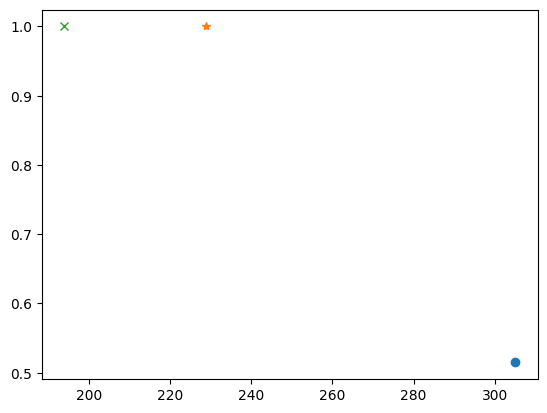

In [ ]:
# # Now implement DT
# import copy
# schedule = copy.deepcopy(schedule_conventional)
# s = 0
# while(True):
#     current = schedule[s]
#     next = schedule[s+1]
#     nextnext = schedule[s+2]

#     if(next.state == 0):
#         reachable_options = [x for x in accesses if x.state == 1 and x.time >= current.time + datetime.timedelta(seconds=agility_bangbang(x.angle - current.angle)) and next.time >= x.time + datetime.timedelta(seconds=agility_bangbang(nextnext.angle - x.angle))]
#         print(reachable_options)
#         if(len(reachable_options) > 0):
#             schedule[s+1] = reachable_options[0]
#             s += 1
#         else:
#             # Delete the next one
#             schedule.pop(s+1)
#             s += 1
    
#     if(s+2 == len(schedule)):
#         break
    

# Plot on graph
eval_conventional = evaluate_schedule(schedule_conventional)
eval_omniscient = evaluate_schedule(schedule_omniscient)
eval_dt = (1004.672098751, 194, 0)

plt.plot(eval_conventional[1], 1 - eval_conventional[2]/eval_conventional[1], 'o', label="Conventional")
plt.plot(eval_omniscient[1], 1 - eval_omniscient[2]/eval_omniscient[1], '*', label="Omniscient")
plt.plot(eval_dt[1], 1 - eval_dt[2]/eval_dt[1], 'x', label="DT")
plt.legend()
plt.xlabel("Number of accesses in schedule")
plt.ylabel("Proportion cloud-free")
plt.grid()
plt.show()


In [3]:
date = datetime.datetime(2025, 1, 1, 0, 0)
# os.chdir('/mnt/c/Users/shree/phd_code/notebooks')
# Download all the masks!!!

masks = []
for i in range(72):
    mask = imagery.load_global_bcm(date + datetime.timedelta(hours=i/2))
    masks.append(mask)


Tight axes size (inches): 7.3 2.4642604494265097


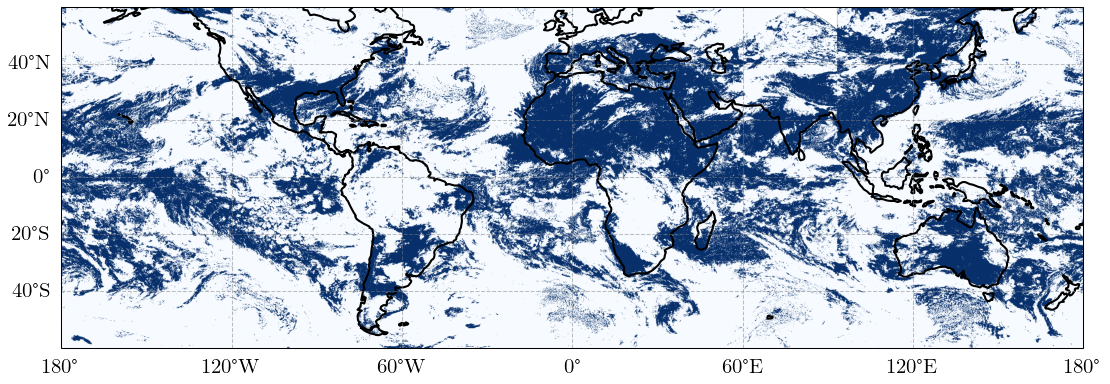

In [6]:
fig, ax = plt.subplots(figsize=(7.6, 4), subplot_kw={'projection': ccrs.PlateCarree()}, dpi=150)
# ax = plt.axes(projection=ccrs.PlateCarree())
im = ax.imshow(masks[0][0], origin='lower', extent=[-180, 180, -60, 60], cmap='Blues_r', transform=ccrs.PlateCarree())

# Add coastlines
ax.coastlines()

# Add gridlines for latitude and longitude
gridlines = ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.5)
gridlines.top_labels = False    # Disable labels at the top
gridlines.right_labels = False  # Disable labels on the right
ax.set_aspect(1)

fig.tight_layout()
fig.canvas.draw()
renderer = fig.canvas.get_renderer()
tight_bbox = ax.get_tightbbox(renderer)

# The bbox is in display (pixel) coordinates; convert to inches:
dpi=150
tight_width_in = tight_bbox.width / dpi
tight_height_in = tight_bbox.height / dpi
print("Tight axes size (inches):", tight_width_in, tight_height_in)
plt.savefig("cloud_mask_example.png")
plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


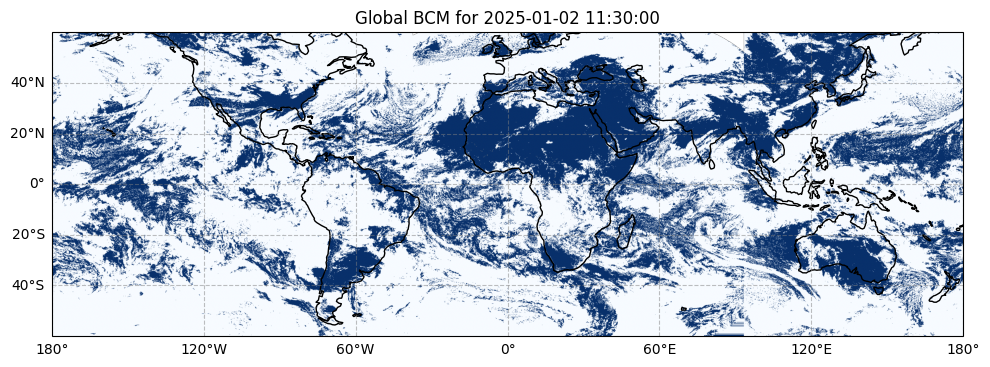

In [21]:
from matplotlib.animation import FuncAnimation

fig = plt.figure(figsize=(10, 4))
ax = plt.axes(projection=ccrs.PlateCarree())
im = ax.imshow(masks[0][0], origin='lower', extent=[-180, 180, -60, 60], cmap='Blues_r', transform=ccrs.PlateCarree())

# Add coastlines
ax.coastlines()

# Add gridlines for latitude and longitude
gridlines = ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.5)
gridlines.top_labels = False    # Disable labels at the top
gridlines.right_labels = False  # Disable labels on the right

fig.tight_layout()
# Function to update the image
# i corresponds to the frame index (hour)
def update(i):
    im.set_array(masks[i][0])  # Update the data in the image
    ax.set_title(f"Global BCM for {date + datetime.timedelta(hours=i/2)}")  # Update the title to indicate the hour
    return im,

# Create the animation
ani = FuncAnimation(fig, update, frames=len(masks), interval=500, blit=True)
ani.save('global_bcm.gif', writer='ffmpeg', fps=10)


In [5]:
full_array = np.stack([x[0] for x in masks], axis=0)
full_array[np.isnan(full_array)] = 0
print(full_array.shape)

lat, long = masks[0][1], masks[0][2]
# Now! Derive the truth map for hour iterations
norm_factor = np.cos(np.deg2rad(lat))
norm_factor_flat = norm_factor.reshape(-1)

truth_map = (full_array == full_array[0, : ,:])

# Global map..
prob_map_total = np.average(truth_map, axis=(1, 2), weights=np.repeat(norm_factor[np.newaxis, :, :], len(masks), axis=0))

flattened_map = full_array.reshape((len(masks), -1))
prob_map_clouds = np.average(flattened_map[:, flattened_map[0, :] == 1] == 1, axis=1, weights=norm_factor_flat[flattened_map[0, :] == 1])
prob_map_noclouds = np.average(flattened_map[:, flattened_map[0, :] == 0] == 0, axis=1, weights=norm_factor_flat[flattened_map[0, :] == 0])

prob_map_stay = np.mean(np.cumsum(flattened_map == flattened_map[0, :], axis=0) == np.arange(len(masks))[:, None] + 1, axis=1)
prob_map_stayclouds = np.mean(np.cumsum(flattened_map[:, flattened_map[0, :] == 1] == 1, axis=0) == np.arange(len(masks))[:, None] + 1, axis=1)
prob_map_staynoclouds = np.mean(np.cumsum(flattened_map[:, flattened_map[0, :] == 0] == 0, axis=0) == np.arange(len(masks))[:, None] + 1, axis=1)

# Divide by the likelihood ratio...
# prob_map_total /= np.mean(truth_map[0, :, :])
# prob_map_clouds /= np.mean(flattened_map[0, :] == 1)
# prob_map_noclouds /= np.mean(flattened_map[0, :] == 0)

flat_prior = np.mean(flattened_map[0, :] == 0)

(72, 1000, 3000)


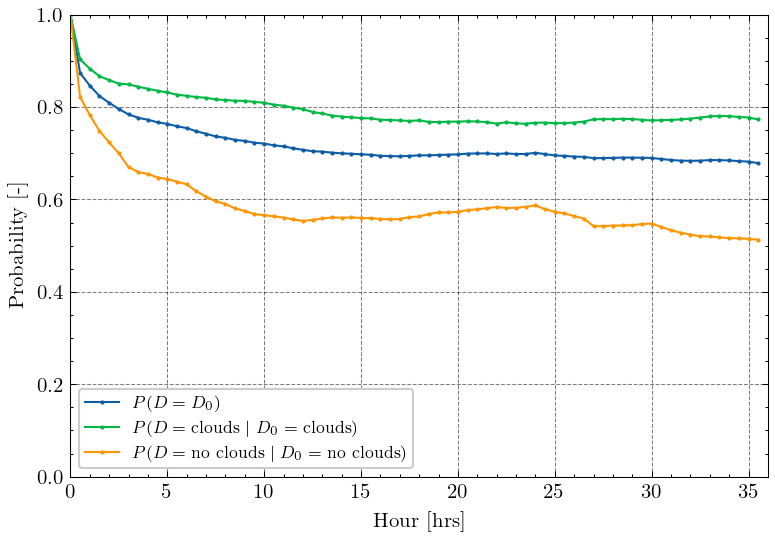

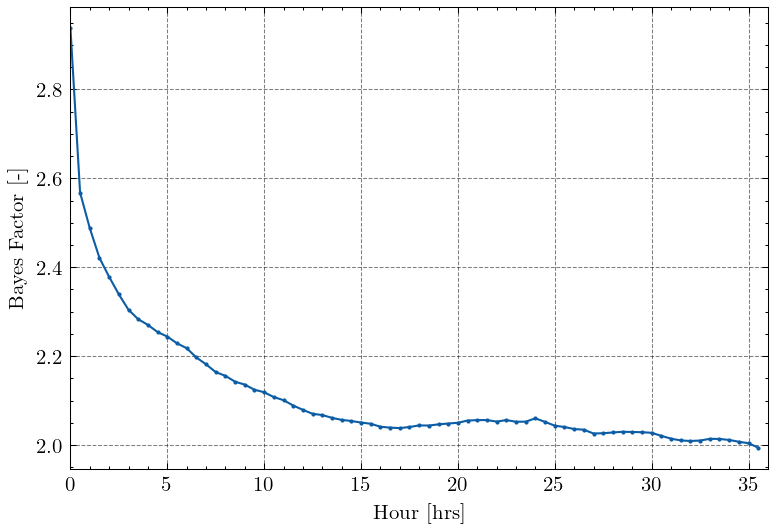

In [10]:
# import scienceplots
# plt.style.use(['science', 'grid'])   

fig, ax = plt.subplots(figsize=(6, 4), dpi=150)
ax.plot(np.arange(0, 36, 0.5) ,prob_map_total, label="$P(D=D_0)$", linestyle='-', marker='.', markersize=2)
ax.plot(np.arange(0, 36, 0.5) ,prob_map_clouds, label="$P(D=\\text{clouds}~|~D_0 = \\text{clouds})$", linestyle='-', marker='.', markersize=2)
ax.plot(np.arange(0, 36, 0.5) ,prob_map_noclouds, label="$P(D=\\text{no clouds}~|~D_0 = \\text{no clouds})$", linestyle='-', marker='.', markersize=2)
ax.set_xlabel("Hour [hrs]")
ax.set_ylabel("Probability [-]")
ax.set_ylim(0, 1)
ax.set_xlim(0, 36)
ax.legend(fontsize=8, loc='lower left')
plt.savefig("cloud_probability.pdf")
plt.show()

# Plot likelihood ratio

fig, ax = plt.subplots(figsize=(6, 4), dpi=150)
ax.plot(np.arange(0, 36, 0.5), prob_map_total / flat_prior, label="Likelihood ratio", marker='.', markersize=2)
ax.set_xlabel("Hour [hrs]")
ax.set_ylabel("Bayes Factor [-]")
ax.set_xlim(0, 36)
plt.savefig("bayes_factor.pdf")
plt.show()

In [11]:
predicted = full_array[0, :, :]
time_steps = full_array.shape[0]

# Initialize lists to hold precision and recall at each time step.
precision = []
recall = []

# For each time delay, compare the persistence forecast (predicted) with the actual state.
# We define "positive" as pixels having the value 1 (clouds).
for t in tqdm(range(time_steps)):
    actual = full_array[t, :, :]
    
    # Compute true positives (TP): predicted 1 and actual 1
    TP = np.sum(norm_factor[(predicted == 1) & (actual == 1)])
    # False positives (FP): predicted 1 but actual not 1
    FP = np.sum(norm_factor[(predicted == 1) & (actual != 1)])
    # False negatives (FN): predicted not 1 but actual is 1
    FN = np.sum(norm_factor[(predicted != 1) & (actual == 1)])
    
    # Avoid division by zero
    prec = TP / (TP + FP) if (TP + FP) > 0 else np.nan
    rec = TP / (TP + FN) if (TP + FN) > 0 else np.nan
    
    precision.append(prec)
    recall.append(rec)

recall = np.array(recall)
precision = np.array(precision)

100%|██████████| 72/72 [00:00<00:00, 74.06it/s]


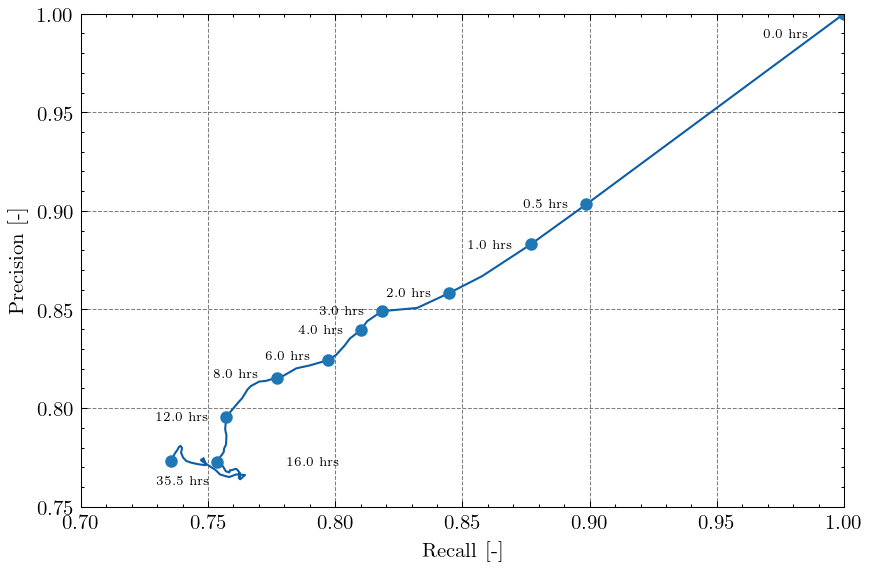

In [12]:
times = np.arange(time_steps)
fig, ax = plt.subplots(figsize=(6, 4), dpi=150)

# Annotation points
annotate_idx = [0, 1, 2, 4, 6, 8, 12, 16, 24, 32, 71]
annotate_offset_x = [-0.007, 0, 0, 0, 0, 0, 0, 0, 0, 0.055, 0.022]
annotate_offset_y = [-0.01, 0, 0, 0, 0, 0, 0.002, 0.002, -0.0, -0.0, -0.01]

for point, offset_x, offset_y in zip(annotate_idx, annotate_offset_x, annotate_offset_y):
    ax.annotate(f"{point/2:.1f} hrs", xy=(recall[point], precision[point]), xytext=(recall[point] - 0.007 + offset_x, precision[point] - 0.00 + offset_y),
                fontsize=6, ha='right', va='center')

plt.plot(recall, precision)
plt.plot(recall[annotate_idx], precision[annotate_idx], 'o', markersize=5, color='tab:blue')
plt.xlabel('Recall [-]')
plt.ylabel('Precision [-]')
plt.xticks(np.arange(0, 1.05, 0.05))
plt.xlim(0.7, 1)
plt.ylim(0.75, 1)
plt.tight_layout()
plt.savefig("global_cloud_pr_curve.pdf")
plt.show()  

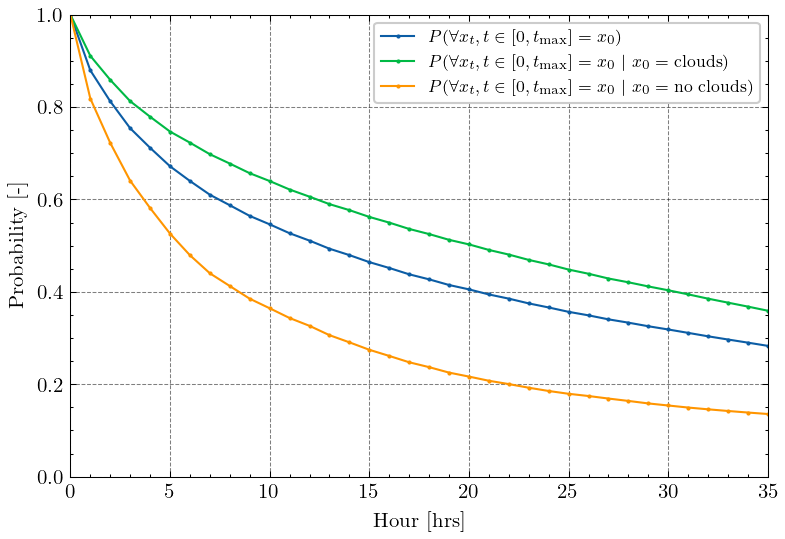

In [15]:
plt.figure(figsize=(6, 4), dpi=150)
plt.plot(prob_map_stay, label=r"$P(\forall x_t, t \in [0, t_{\text{max}}]=x_0)$", marker='.', markersize=2)
plt.plot(prob_map_stayclouds, label=r"$P(\forall x_t, t \in [0, t_{\text{max}}]=x_0~|~x_0 = \text{clouds})$", marker='.', markersize=2)
plt.plot(prob_map_staynoclouds, label=r"$P(\forall x_t, t \in [0, t_{\text{max}}]=x_0~|~x_0 = \text{no clouds})$", marker='.', markersize=2)

plt.xlabel("Hour [hrs]")
plt.ylabel("Probability [-]")
plt.ylim(0, 1)
plt.xlim(0, 35)
plt.legend(fontsize=8)
plt.savefig("global_cloud_change_probability.pdf")
plt.show()



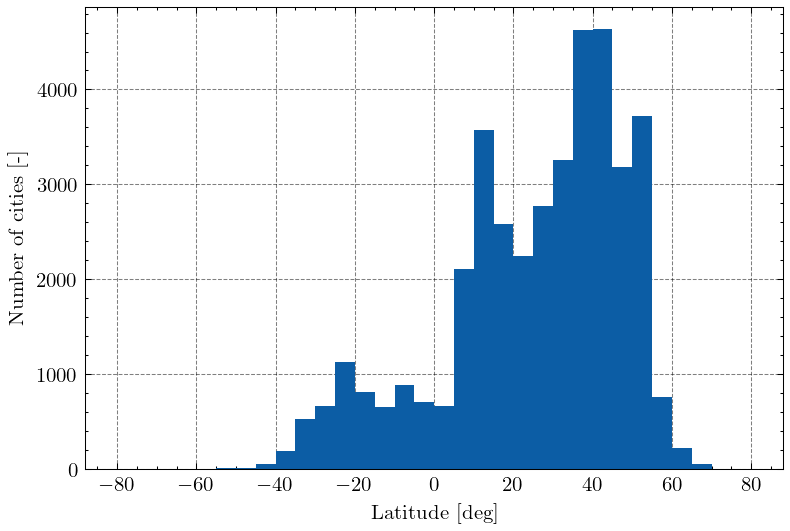

In [ ]:
# os.chdir('/mnt/c/Users/shree/phd_code/notebooks')

city_lats = [x.lat for x in load_worldcities(40000)]

plt.figure(figsize=(6, 4), dpi=150)
plt.hist(city_lats, bins=np.arange(-80,85, 5))
plt.xlabel("Latitude [deg]")
plt.ylabel("Number of cities [-]")
plt.show()


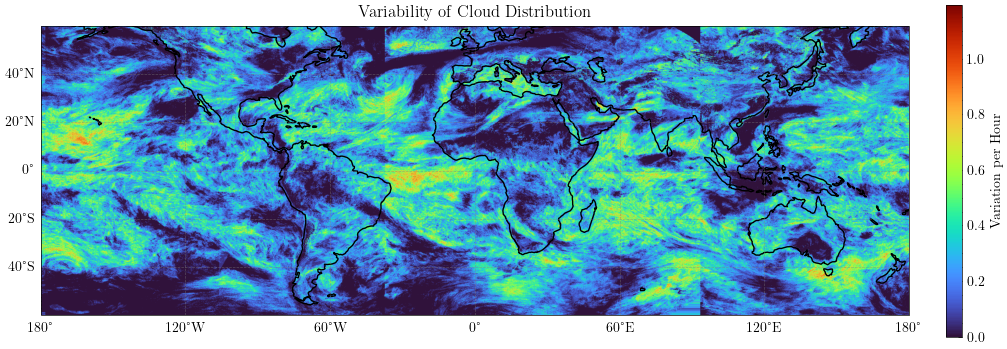

In [21]:
variability = np.sum(np.abs(np.diff(full_array, axis=0)), axis=(0))/(full_array.shape[0] * 0.5)
fig = plt.figure(figsize=(10, 4))
ax = plt.axes(projection=ccrs.PlateCarree())
im = ax.imshow(variability, origin='lower', extent=[-180, 180, -60, 60], cmap='turbo', transform=ccrs.PlateCarree())

# Add coastlines
ax.coastlines()

# Add gridlines for latitude and longitude
gridlines = ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.5)
gridlines.top_labels = False    # Disable labels at the top
gridlines.right_labels = False  # Disable labels on the right


plt.title('Variability of Cloud Distribution')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.tight_layout()
plt.colorbar(im, label='Variation per Hour', fraction=0.018, pad=0.04)
plt.show()